[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ducis28/sg-dlfs4/blob/main/dlfs4_ch08.ipynb)

# 『ゼロから作るDeep Learning ❹ 強化学習編』

https://github.com/oreilly-japan/deep-learning-from-scratch-4

## 第8章 DQN

- DQN (Deep Q Network)
- DQN では「経験再生」と「ターゲットネットワーク」を使う
- DQN を拡張した手法（「Double DQN」「優先度付き経験再生」「Dueling DQN」）も取り上げる
- 本章では「グリッドワールド」でなく「カートポール」という問題を扱う

### 8.1 OpenAI Gym

- OpenAI Gym (GitHub) https://github.com/openai/gym

> The team that has been maintaining Gym since 2021 has moved all future development to [Gymnasium](https://github.com/Farama-Foundation/Gymnasium), a drop in replacement for Gym (import gymnasium as gym), and Gym will not be receiving any future updates. Please switch over to Gymnasium as soon as you're able to do so. If you'd like to read more about the story behind this switch, please check out [this blog post](https://farama.org/Announcing-The-Farama-Foundation).

とのことで，2023年6月現在，Gym の開発は既に停止している（最終リリースは 2022年10月5日）。

今後の開発は開発体制と名前を変えて Gymnasium として継続される。利用方法もほぼ同じで，`import gym` の代わりに `import gymnasium as gym` とすれば，古いコードがほぼそのまま動く（実際にはいくつか調整が必要な場合が多い）。

変更点などについては[この記事](https://zenn.dev/ymd_h/scraps/6e6b03b4ebd5ce)が参考になる。

#### 8.1.1 OpenAI Gym の基礎知識

In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 19.0 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym

In [ ]:
env = gym.make('CartPole-v0')

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


CartPole のバージョン 0 を読み込むと，Deprecation Warning（非推奨の警告）が表示される。

バージョン 1 を使うべきである。

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
## Gym では
#state = env.reset()
#print(state)  # 初期状態

## Gymnasium では
observation, info = env.reset()
print(observation)  # 初期状態

[ 0.02417546  0.03626963 -0.00738724  0.03899148]


In [ ]:
action_space = env.action_space
print(action_space)  # 行動の次元数

Discrete(2)


「状態」は 4 種類，「行動」は 2 種類ある。

状態や行動の意味については，CartPole のドキュメントに記載されている。

https://gymnasium.farama.org/environments/classic_control/cart_pole/

- 行動（action）
  - 0: カートを左に押す
  - 1: カートを右に押す
- 状態（state）あるいは観測（observation）
  - 0: カートの位置（$-4.8$ から $+4.8$）
  - 1: カートの速度（$-\infty$ から $\infty$）
  - 2: 棒の角度（$-0.418$ rad から $+0.418$ rad）
  - 3: 棒の角速度（$-\infty$ から $\infty$）

以下は，ある状態においてある行動（action=0）をおこなったときに環境からの報酬・観測（次の状態）などを取得する例である。
gym 用のコードとは少し異なる。

In [ ]:
action = 0  # or 1
#next_state, reward, done, info = env.step(action)
observation, reward, terminated, truncated, info = env.step(action)
print(f'{observation = }')
print(f'{reward      = }')
print(f'{terminated  = }')
print(f'{truncated   = }')
print(f'{info        = }')

observation = array([ 0.02490085, -0.15874562, -0.00660741,  0.32933453], dtype=float32)
reward      = 1.0
terminated  = False
truncated   = False
info        = {}


- observation（観測）: 次の状態
- reward（報酬）: スカラ値であり，バランスが保たれている間は常に $1$ の報酬が得られる。
- terminated（終了）: エピソードが終了したかどうかを表す真理値
- truncated（打ち切り）: エピソードが途中で打ち切られたかどうかを表す真理値
- info: デバッグ用の有益な情報。

#### 8.1.2 ランダムなエージェント

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make('CartPole-v1', render_mode='rgb_array')
state = env.reset()
terminated = False
truncated = False

while not terminated and not truncated:
    rgb_data = env.render()
    action = np.random.choice([0, 1])
    observation, reward, terminated, truncated, info = env.step(action)
env.close()

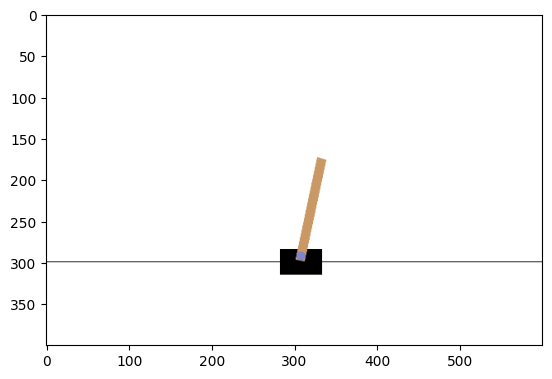

In [ ]:
plt.imshow(rgb_data)
plt.show()

ローカル環境であれば，`gym.make()` の引数において `render_mode='human'` のように指定することでウィンドウが開き，実際にカートと棒が動く様子を見ることができる。

Colab は，自身の PC に新たなウィンドウを開く機能を持たないないため，カートの動きを表示させるには工夫が必要である。

たとえば，[renderlab](https://github.com/ryanrudes/renderlab) を用いる方法が有効である。

ちなみに，かつては Gym の Monitor や RecordVideo を用いる方法もあった（たとえば[この記事](https://zenn.dev/ymd_h/articles/36eff0de1ee5ed)を参照）が，いずれも Gymnasium では対応していないようである。

In [ ]:
!pip install renderlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gymnasium as gym
import renderlab as rl

env = gym.make('CartPole-v1', render_mode = 'rgb_array')
env = rl.RenderFrame(env, './output')

observation, info = env.reset()
terminated = False
truncated = False

while not terminated and not truncated:
  action = env.action_space.sample()  # np.random.choice() と同様
  observation, reward, terminated, truncated, info = env.step(action)

env.play()
env.close()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  57%|█████▋    | 17/30 [00:00<00:00, 169.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1687409691.3225658.mp4, 720000 bytes wanted but 0 bytes read,at frame 29/30, at time 0.97/0.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


renderlab では [MoviePy](https://zulko.github.io/moviepy/) を用いて動画を扱っており，そのようなメッセージが表示される。このメッセージは邪魔なので消したい。

https://github.com/ryanrudes/renderlab/blob/main/renderlab/render_frame.py

`verbose=False` で良さそうだが実は deprecated で，`logger=None` としなければならないらしい。

https://zulko.github.io/moviepy/_modules/moviepy/video/VideoClip.html

#### 【補足】状態と観測について

- 状態（state）: 環境に関しての「完全な記述（情報）」
- 観測（observation）: 状態の「部分的な記述」（例：ポーカーや麻雀など）

### 8.2 DQN のコア技術

Q 学習は推定値を使って推定値を更新する（ブートストラッピング）。そのため不安定になりやすい。

ニューラルネットワークも表現力が高いことが裏目に出て，過学習（overfitting）によって不安定になりやすい。

DQN は Q 学習とニューラルネットワークを組み合わせる手法であるため，さらに不安定になりやすい。

そこで，ニューラルネットワークの学習を安定させるために

- 経験再生（experience replay）
- ターゲットネットワーク（target network）

を用いる。

#### 8.2.1 経験再生（Experience Replay）

ニューラルネットワークを教師あり学習に適用する例は多数みられるが，強化学習に適用するのは難しく，2013年の DQN まではほとん
ど例が見られなかった。

なぜニューラルネットワークを強化学習（特に Q 学習）に適用するのは難しいのか？

- 教師あり学習: 訓練用データセットから，ランダムにデータを抽出してミニバッチを作成し，ミニバッチ単位でパラメータの更新をおこなう。ミニバッチに偏りがないように，ランダムに選ぶことが望ましい。
- Q 学習: 経験データは時刻 $t$ ごとに $E_1, E_2, \cdots, E_t, \cdots$ のように得られる。近接するデータはランダムでなく，強い相関がある。

この違いを埋めるテクニックが経験再生である。

**経験再生** では，まずエージェントが経験したデータを一度バッファに保存し，Q 関数を更新する際にはバッファから経験データをランダムに取り出す。

経験再生は Q 学習に限らず他の強化学習アルゴリズムにも適用できるが，方策オフ型に限られる（方策オン型は，現時点の方策から得たデータだけしか使えないため）。

#### 8.2.2 経験再生の実装

経験再生のバッファは，適当なサイズを定め，FIFO 形式でデータを格納する。

In [ ]:
from collections import deque
import random
import numpy as np


class ReplayBuffer:
    def __init__(self, buffer_size: int, batch_size: int):
        """
        buffer_size: バッファのサイズ
        batch_size: ミニバッチのサイズ
        """
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done

In [ ]:
# 上のコードでは np.stack と np.array を使い分けているが，結果は同じになる気がする

for shape in [(10,), (10, 10), (10, 10, 10)]:
    data = np.random.rand(*shape)
    data = list(data)
    x1 = np.stack(data)
    x2 = np.array(data)
    print(shape, x1.shape == x2.shape)

(10,) True
(10, 10) True
(10, 10, 10) True


In [ ]:
# 上のコードは似たような list comprehension をたくさん使って実装している。
# np.Generator.choice() で同様の事ができそうである。
# しかし，state や action の次元や形状が統一されていないため，一般にはそれができない。
#
# ちなみに，np.Generator.choice() と似たようなメソッドである np.random.choice() は 1-D array にしか対応しておらず，今回のように 2-D （あるいはそれ以上）には適用できない。
# さらに言えば，np.random.choice() は古い方法であるから，保守性の高いコードを書く目的があるのであれば np.Generator.choice() を使うべき，らしい。

In [ ]:
import gymnasium as gym
import renderlab as rl

env = gym.make('CartPole-v1', render_mode = 'rgb_array')
env = rl.RenderFrame(env, './output')

replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10):
    observation, info = env.reset()
    done = False

    while not done:
        action = 0  # 常に左へ動かす
        observation, reward, terminated, truncated, info = env.step(action)
        next_state = observation
        done = terminated or truncated
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

state, action, reward, next_state, done = replay_buffer.get_batch()

print(state.shape)  # (32, 4)
print(action.shape)  # (32,)
print(reward.shape)  # (32,)
print(next_state.shape)  # (32, 4)
print(done.shape)  # (32,)

(32, 4)
(32,)
(32,)
(32, 4)
(32,)


#### 8.2.3 ターゲットネットワーク（Target Network）

- 教師あり学習では正解ラベルが変化することはない。例えば，画像の数字認識において，最初はある画像の正解ラベルが「４」だったときに同じ画像の正解ラベルが途中で「７」に変化することはあり得ない。
- Q 学習において正解ラベルといえるものは TD ターゲット $R_t+\gamma \max_a Q(S_{t+1},a)$ であるが，これは訓練途中における推定値であるため，訓練が進むことによって TD ターゲットの値が変化する可能性がある。

この違いを埋めるためにターゲットネットワークを用いて TD ターゲットを固定する。

ターゲットネットワークでは，

- まず Q 関数のオリジナルネットワークを用意する（これを `qnet` とする）
- 次に同じ構造のネットワークをもう１つ用意する（これを `qnet_target` とする）
- `qnet` は通常の Q 学習によって更新する
- `qnet_target` は常に更新するのではなく，定期的に（たとえば 100 エピソードごとに） `qnet` の重みと同期する

#### 8.2.4 ターゲットネットワークの実装

In [ ]:
!pip install dezero

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import copy
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

In [ ]:
# 通常の Q ネットワーク
class QNet(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [ ]:
class DQNAgent:
    """
    ２つの Q ネットワーク qnet, qnet_target を持つエージェント
    """

    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        # 経験再生のためのバッファ
        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)

        # （通常の）Q ネットワーク
        self.qnet = QNet(self.action_size)

        # ターゲット Q ネットワーク
        self.qnet_target = QNet(self.action_size)

        # オプティマイザは Adam
        self.optimizer = optimizers.Adam(self.lr)

        # オプティマイザによって更新されるのは qnet のみ
        # （qnet_target は更新せず，他の方法で定期的に更新する）
        self.optimizer.setup(self.qnet)  # qnet を設定

    def sync_qnet(self):
        """
        2 つのニューラルネットワークを同期する
        """
        # deepcopy によって「深いコピー」をおこない完全な複製を作る
        self.qnet_target = copy.deepcopy(self.qnet)

    def get_action(self, state):
        """
        ある状態 state において，現在の方策にしたがって行動を 1 つ選択する
        """
        # 探索（exploration）
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        # 活用（exploitation）
        else:
            # バッチの次元を追加
            # 例: shape (5,) が (1, 5) になる
            state = state[np.newaxis, :]

            # ある状態における Q 関数（行動価値関数）を求める
            qs = self.qnet(state)

            # dezero 変数から単純な数値ベクトルを取得し，
            # そのうち最大値の添字を求める
            return qs.data.argmax()

In [ ]:
state = np.random.rand(5)
print(state)
print(state.shape)
state = state[np.newaxis, :]
print(state)
print(state.shape)

[0.5773095  0.51896126 0.85317777 0.86952685 0.51538202]
(5,)
[[0.5773095  0.51896126 0.85317777 0.86952685 0.51538202]]
(1, 5)


In [ ]:
qnet = QNet(2)
state = np.random.rand(4)
state = state[np.newaxis, :]
qs = qnet(state)
qs

variable([[-0.38438189  0.30894685]])

In [ ]:
type(qs)

dezero.core.Variable

In [ ]:
qs.data

array([[-0.38438189,  0.30894685]])

In [ ]:
qs.data.argmax()

1

次に update() メソッドについて

In [ ]:
class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)  # qnet を設定

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]
            qs = self.qnet(state)
            return qs.data.argmax()

    # 追加
    def update(self, state, action, reward, next_state, done):
        """
        重みパラメータを更新する
        """
        # 経験データをバッファに追加する
        self.replay_buffer.add(state, action, reward, next_state, done)

        # 経験データの数がミニバッチサイズに満たなければ何も更新せずに続ける
        if len(self.replay_buffer) < self.batch_size:
            return

        # ミニバッチを取り出す
        state, action, reward, next_state, done = self.replay_buffer.get_batch()

        # 状態は shape=(4,) だが，ここの state はミニバッチ化されているので
        # shape=(32, 4) となる（ミニバッチサイズが 32 の場合）。
        # qnet の forward によって各行動についての Q 関数の値を求める。
        # 戻り値 qs の shape は (32, 2) となる。
        # 2 は行動サイズ。
        qs = self.qnet(state)

        # action は行動 (0/1) がミニバッチ化されたもので，
        # shape=(32,) となる。
        # action に対応する Q 関数の値を求める。
        # 戻り値のサイズは (32,) となる。
        # ここは np.arange(self.batch_size) でなく : で良いのでは？
        q = qs[np.arange(self.batch_size), action]

        # 次の状態における Q 関数の値を求める。
        # qnet でなく qnet_target を用いて計算する。
        # 戻り値 next_qs の shape は (32, 2)
        next_qs = self.qnet_target(next_state)

        # ミニバッチの各データごとに最大値を求める。
        # 戻り値 next_q の shape は (32,)
        next_q = next_qs.max(axis=1)

        # バックプロパゲーション（勾配計算）をおこなわない。
        next_q.unchain()

        # エピソードの終端なら reward そのものを，
        # そうでなければ TD ターゲットを求める。
        # 戻り値のサイズは next_q と同じ (32,)
        target = reward + (1 - done) * self.gamma * next_q

        # 損失関数（現在の Q 関数とターゲットとのズレ）を求める。
        loss = F.mean_squared_error(q, target)

        # いつものやつ
        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()  # 更新されるのは qnet のみ

#### 8.2.5 DQN を動かす

300 エピソードの学習をおこなう。
20 エピソードごとにターゲットネットワークの同期をおこなう。

episode: 0, total reward: 12.0
episode: 10, total reward: 20.0
episode: 20, total reward: 9.0
episode: 30, total reward: 9.0
episode: 40, total reward: 8.0
episode: 50, total reward: 9.0
episode: 60, total reward: 10.0
episode: 70, total reward: 10.0
episode: 80, total reward: 10.0
episode: 90, total reward: 9.0
episode: 100, total reward: 9.0
episode: 110, total reward: 64.0
episode: 120, total reward: 94.0
episode: 130, total reward: 168.0
episode: 140, total reward: 248.0
episode: 150, total reward: 173.0
episode: 160, total reward: 232.0
episode: 170, total reward: 207.0
episode: 180, total reward: 111.0
episode: 190, total reward: 161.0
episode: 200, total reward: 161.0
episode: 210, total reward: 242.0
episode: 220, total reward: 303.0
episode: 230, total reward: 293.0
episode: 240, total reward: 202.0
episode: 250, total reward: 229.0
episode: 260, total reward: 397.0
episode: 270, total reward: 254.0
episode: 280, total reward: 500.0
episode: 290, total reward: 301.0


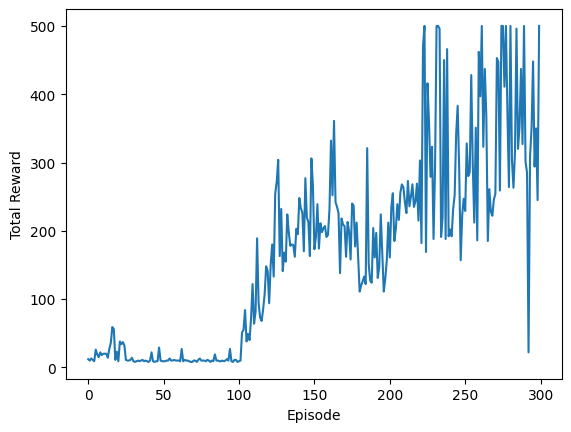

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Total Reward: 500.0


In [ ]:
import copy
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import renderlab as rl
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done


class QNet(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]
            qs = self.qnet(state)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)
        q = qs[np.arange(self.batch_size), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)

episodes = 300
sync_interval = 20
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
env = rl.RenderFrame(env, './output')
agent = DQNAgent()
reward_history = []

for episode in range(episodes):
    observation, info = env.reset()
    state = observation
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        observation, reward, terminated, truncated, info = env.step(action)
        next_state = observation
        done = terminated or truncated

        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    if episode % 10 == 0:
        print(f'episode: {episode}, total reward: {total_reward}')


# === Plot ===
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(range(len(reward_history)), reward_history)
plt.show()


# === Play CartPole ===
agent.epsilon = 0  # greedy policy
observation, info = env.reset()
state = observation
done = False
total_reward = 0

while not done:
    action = agent.get_action(state)
    observation, reward, terminated, truncated, info = env.step(action)
    next_state = observation
    done = terminated or truncated

    state = next_state
    total_reward += reward
    env.render()

env.play()
env.close()
print('Total Reward:', total_reward)

同じ実験を100回おこなって平均をとる，というのは省略（時間がかなりかかる）。

学習後のエージェントに greedy な行動をとらせたものが，上の動画。
500ステップで打ち切られるまで，完全にバランスをとることができた。

### 8.3 DQN と Atari

- DQN 論文: https://doi.org/10.48550/arXiv.1312.5602
  - Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, Martin Riedmiller
  - "Playing Atari with Deep Reinforcement Learning"
  - NIPS Deep Learning Workshop 2013

DQN 論文のタイトルにある「Atari」とは[コンピュータゲーム制作会社](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%82%BF%E3%83%AA_(%E4%BC%81%E6%A5%AD))（知らなかったが，2023年の今もまだある）。
論文では Atari 社が制作した昔のゲームソフトのことを Atari と呼んでいる。

カートポールよりも複雑な，Atari の学習にはかなり時間がかかる。

#### 8.3.1 Atari のゲーム環境

Gymnasium に Atari の学習環境が用意されている。

- https://gymnasium.farama.org/environments/atari/

Gymnasium の Atari 環境では [Arcade Learning Environment (ALE)](https://github.com/mgbellemare/Arcade-Learning-Environment) を利用している。
ゲームソフトの ROM データの取り扱いには注意が必要。

> ALE-py doesn’t include the atari ROMs (`pip install gymnasium[atari]`) which are necessary to make any of the atari environments. To install the atari ROM, use `pip install gymnasium[accept-rom-license]` which will install AutoROM and download the ROMs, install them in the default location. In doing so, you agree to own a license to these Atari 2600 ROMs and agree to not distribution these ROMS.
>
> It is possible to install the ROMs in an alternative location, [AutoROM](https://github.com/Farama-Foundation/AutoROM) has more information.

ここでは Pong というゲームを扱う。

ボールを打ち合うゲームで，左側に敵のボード，右側にプレイヤ自身のボードがあり，それぞれ上下に動かすことができる。

- 状態: ゲームの画像（横201，縦160，RGB 3 チャンネル）
- 行動: 自身の（右側の）ボードを上下に動かすなど，6つの行動

#### 8.3.2 前処理

カートポールと違い，Pong の observation には「速度」の情報が含まれない。現在の画像が observation である。したがって，次の状態を予測するために必要な情報が不足している。

つまり，Pong 環境は MDP（マルコフ決定過程）ではない。
POMDP（部分観測マルコフ決定過程; partially observable Markov decision process）とよばれる。

DQN 論文では，4フレームの画像を重ね合わせて1つの「状態」とすることでボールの動きを判断できるようにして，POMDP を MDP に変形して解いている，らしい。一方で，POMDP を RNN で扱う手法もある。

DQN では画像を重ね合わせる前に以下の処理をおこなっている。

- 画像の周囲の無駄な部分をトリミング
- グレイスケールへの変換
- リサイズ
- 正規化（画像の要素（明度？）を 0.0 から 1.0 の間に変換）


#### 8.3.3 CNN

カートポールでは全結合層を用いた。

画像を扱う Pong では CNN（畳み込みニューラルネットワーク; convolutional neural network）が有効である。

#### 8.3.4 その他の工夫

- GPU の使用
- $\varepsilon$ の調整
  - 初期の段階では探索を多く，徐々に少なく
  - DQN論文では，
    - 最初の100万ステップは $\varepsilon$ を $1.0$ から $0.1$ まで線形に減少させる。
    - それ以降は $\varepsilon=0.1$ で固定
- 報酬クリッピング（reward clipping）
  - DQN 論文では，報酬を $-1.0$ から $1.0$ の範囲に収まるように調整している
  - Pong 環境ではもともと報酬が $-1,0,1$ のいずれかであるため，調整は不要

### 8.4 DQN の拡張

#### 8.4.1 Double DQN

- [13] Van Hasselt, Hado, Arthur Guez, and David Silver. “Deep reinforcement
learning with double q-learning.” Proceedings of the AAAI conference on
artificial intelligence. Vol. 30. No. 1. 2016.
  - https://doi.org/10.48550/arXiv.1509.06461

TD ターゲットを

- $\displaystyle R_t + \gamma \max_a Q_{\theta'}(S_{t+1},a)$ から
- $\displaystyle R_t + \gamma Q_{\theta'}(S_{t+1},\underset{a} {\operatorname{argmax}} Q_{\theta}(S_{t+1},a))$ に変更する

これにより，Q 関数の過大評価を避けることができる。

詳しくは「付録C Double DQN の理解」を参照。

#### 8.4.2 優先度付き経験再生

- [14] Schaul, Tom, et al. “Prioritized experience replay.” arXiv preprint
arXiv:1511.05952 (2015).
  - https://doi.org/10.48550/arXiv.1511.05952

経験データをランダムに（一様分布にもとづいて）選ぶのではなく，優先度にしたがって選ぶ。

経験データの優先度は

$$
\delta_t = \left| R_t + \gamma \max_a Q_{\theta'}(S_{t+1},a) - Q_{\theta}(S_t,A_t) \right|
$$

つまり，

- TD ターゲット $\displaystyle R_t + \gamma \max_a Q_{\theta'}(S_{t+1},a)$
- 現在方策におけるの Q 関数の値 $Q_{\theta}(S_t,A_t)$

の差の絶対値を優先度とする。

要するに，大きく間違っているところ（学ぶべきことが多いところ）に注目して優先的に訓練をおこなう，ということ。

優先度付き経験再生では，経験データを保存するときに優先度 $\delta_t$ も計算し，$(S_t,A_t,R_t,S_{t+1},\delta_t)$ をバッファに格納する。

バッファから経験データを取り出す際には，第 $i$ 番目のデータを取り出す確率が $\delta_i$ に比例するようにする。

#### 8.4.3 Dueling DQN

- [15] Wang, Ziyu, et al. “Dueling network architectures for deep reinforcement
learning.” International conference on machine learning. PMLR, 2016.
  - https://doi.org/10.48550/arXiv.1511.06581

以下の **アドバンテージ関数（advantage fuction）** を用いる。

$$
A_\pi(s,a) = Q_\pi(s,a) - V_\pi(s)
$$

ここで，状態 $s$ において，

- $Q_\pi(s,a)$ : ある決まった行動 $a$ をとるときの価値
- $V_\pi(s)$: 方策 $\pi$ にしたがって選ばれた行動をとるときの価値

であるから，アドバンテージ関数の値が大きさは，行動 $a$ が現状の方策 $\pi$ で選ばれる行動と比べてどれくらい良いかを表している，と解釈できる。

上の式を変形すると

$$
Q_\pi(s,a) = A_\pi(s,a) + V_\pi(s)
$$

となる。

ネットワークとして途中までを共有しながら，途中で枝分かれして，アドバンテージ関数 $A_\pi(s,a)$ と状態価値関数 $V_\pi(s)$ をそれぞれ訓練するようなネットワークを考えることができる。これが Dueling DQN である。

アドバンテージ関数と状態価値関数を分離して学習することが有効であるのはどんな状況だろうか。たとえば，「ある状態 $s$ において，どんな行動をしても結果がほとんど変わらない（勝敗や，得られる報酬がほぼ確定している）」ような状況においては有効である。

より具体的には，Pong で，ボールが自陣に到達する直前で，バーを速く動かしても間に合わないような状況がそれにあたる。いろんな行動を試さずとも，$V(s)$ が適切に更新されれば $Q(s,a)$ の値がまとめて更新されるようになる。

### 8.5 まとめ

- DQN でキーとなるのは
  - 経験再生: データ効率が良くなり，サンプル間にある相関性を減らすことができる
  - ターゲットネットワーク: TD ターゲットが固定され，ニューラルネットワークの学習が安定する
- DQN を拡張した手法